## eBOSS configuration files

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import bossdata
import fitsio
import os

In [3]:
from astropy.io import fits
from specsim import config, instrument

In [4]:
bossdata.__version__

'0.2.9dev'

In [5]:
finder = bossdata.path.Finder()
mirror = bossdata.remote.Manager()

In [251]:
10**(0.0001)-1

0.00023028502082467206

In [252]:
np.log(10)*0.0001

0.0002302585092994046

In [6]:
plates = [7027, 6963, 7301, 6759, 6002, 6178, 6626, 6882, 7389, 7453, 
          7517, 7276, 6390, 6472, 6660, 6877, 6970, 7451, 6122, 6261]
mjds =  [56448, 56724, 56746, 56416, 56104, 56213, 56330, 56541, 56769, 56749, 
         56772, 57061, 56244, 56362, 56370, 56544, 56444, 56739, 56246, 56219]

In [8]:
combined = False
plan_path = finder.get_plate_plan_path(plate=plates[0], mjd=mjds[0], combined=combined)
plan_path = mirror.get(plan_path)

In [254]:
exposures = {}
exposure_table = astropy.table.Table(
            names=('flavor', 'exp', 'mjd', 'exptime', 'cameras'), dtype=('S12', 'i4', 'i4', 'f4', 'S12'))
with open(plan_path, 'r') as f:
    for line in f:
        if not line.startswith('SPEXP'):
            continue
        tokens = line.split()
        print(tokens[4])
        if not plate:
            plate = int(tokens[1])
        elif plate != int(tokens[1]):
            raise RuntimeError('Internal error: unexpected plate {0} in {1}.'.format(
                tokens[1], path))
        # Validate the exposure names, which should all have the form
        # [prefix]-[cc]-[eeeeeeee].fits
        exposure_id = set()
        specs = set()
        for name in tokens[7:11]:
            if name == 'UNKNOWN':
                continue
            name, ext = os.path.splitext(name)
            #if ext != '.fits':
                #raise RuntimeError('Unexpected extension {} in {}.'.format(ext, mirror.get(plan_path)))
            fields = name.split('-')
            if len(fields) != 3:
                raise RuntimeError(
                    'Unexpected exposure name {} in {}.'.format(name, path))
            if fields[0] not in ('sdR', 'spFrame'):
                raise RuntimeError(
                    'Unexpected prefix {} in {}.'.format(fields[0], path))
            if fields[1] not in ('r1', 'b1', 'r2', 'b2'):
                raise RuntimeError(
                    'Unexpected camera {} in {}.'.format(fields[1], path))
            exposure_id.add(int(fields[2]))
            specs.add(fields[1])
        if len(exposure_id) != 1:
            raise RuntimeError('Multiple exposure IDs: {}.'.format(exposure_id))
        # Build an exposure record to save.
        exposure = dict(
            MJD=tokens[2], EXPTIME=float(tokens[5]),
            EXPID=exposure_id.pop(), SPECS=specs)
        # Record this exposure under the appropriate category.
        flavor = tokens[4]
        if flavor in exposures:
            exposures[flavor].append(exposure)
        else:
            exposures[flavor] = [exposure]
        if 'science' in exposures:
            num_science_exposures = len(exposures['science'])
        else:
            num_science_exposures = 0
        # Remember the number of fibers on this plate.
        num_fibers = bossdata.plate.get_num_fibers(plate)
        # Build a table of science exposure info.
        for exposure in exposures[flavor]:
            exposure_table.add_row((
                flavor, exposure['EXPID'], exposure['MJD'], exposure['EXPTIME'],
                ','.join(sorted(exposure['SPECS']))))

arc
flat
science
science
science


In [255]:
exposure_info = exposures['flat'][0] #do some observations have multiple sets of flats? if yes, incorporate into Plate as num_flat_exposures
exposure_info

{'EXPID': 162792,
 'EXPTIME': 30.84,
 'MJD': '56448',
 'SPECS': {'b1', 'b2', 'r1', 'r2'}}

In [256]:
exposure_table

flavor,exp,mjd,exptime,cameras
str12,int32,int32,float32,str12
arc,162791,56448,4.84,"b1,b2,r1,r2"
flat,162792,56448,30.84,"b1,b2,r1,r2"
science,162793,56448,900.84,"b1,b2,r1,r2"
science,162793,56448,900.84,"b1,b2,r1,r2"
science,162794,56448,900.83,"b1,b2,r1,r2"
science,162793,56448,900.84,"b1,b2,r1,r2"
science,162794,56448,900.83,"b1,b2,r1,r2"
science,162795,56448,900.83,"b1,b2,r1,r2"


In [12]:
bossdata.__version__

'0.2.8'

In [9]:
PPlan = bossdata.plate.Plan(plan_path)

In [298]:
print(PPlan.get_exposure_name(sequence_number=0, band='red', fiber=3, ftype='spCFrame'))
print(PPlan.get_exposure_name(sequence_number=1, band='red', fiber=3, ftype='spCFrame'))
print(PPlan.get_exposure_name(sequence_number=2, band='red', fiber=3, ftype='spCFrame'))

spCFrame-r1-00162793.fits
spCFrame-r1-00162794.fits
spCFrame-r1-00162795.fits


In [301]:
PPlan.exposures['science']

[{'EXPID': 162793,
  'EXPTIME': 900.84,
  'MJD': '56448',
  'SPECS': {'b1', 'b2', 'r1', 'r2'}},
 {'EXPID': 162794,
  'EXPTIME': 900.83,
  'MJD': '56448',
  'SPECS': {'b1', 'b2', 'r1', 'r2'}},
 {'EXPID': 162795,
  'EXPTIME': 900.83,
  'MJD': '56448',
  'SPECS': {'b1', 'b2', 'r1', 'r2'}}]

In [11]:
plate_spec_path = finder.get_plate_spec_path(plate=plates[0], mjd=mjds[0])
plate_spec_path = mirror.get(plate_spec_path)

spPlate-7027-56448.fits 100%|#####################################| 457.70  B/s


In [13]:
PlateFile = bossdata.plate.PlateFile(plate_spec_path)

In [17]:
PlateFile.exposures.table

offset,camera,science,flat,arc
int32,str2,int32,int32,int32
0,b1,162793,162792,162791
1,b1,162794,162792,162791
2,b1,162795,162792,162791
3,b2,162793,162792,162791
4,b2,162794,162792,162791
5,b2,162795,162792,162791
6,r1,162793,162792,162791
7,r1,162794,162792,162791
8,r1,162795,162792,162791


### FWHM resolution as a function of wavelength for all fibers in a given plate

In [7]:
fwhm = np.sqrt(8*np.log(2))

def get_hdulist(sequence_number, band, fiber, plan_path):
    local_plan_path = mirror.get(plan_path)
    Plan = bossdata.plate.Plan(local_plan_path)
    exp_name = Plan.get_exposure_name(sequence_number=sequence_number, band=band, fiber=fiber, ftype='spCFrame')
    spec_index = Plan.get_spectrograph_index(fiber=fiber)
    local_fits = mirror.get(os.path.join(plan_path.strip(os.path.basename(plan_path)), exp_name))
    hdulist = fits.open(local_fits)
    Frame = bossdata.plate.FrameFile(path=local_fits, index=spec_index, calibrated=True)
    return(hdulist, Frame.camera)


def plot_cameras(plate, mjd, sequence_number=1, rms=False, plot=True):
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    b1_hdulist, b1_title = get_hdulist(sequence_number=sequence_number, band='blue', fiber=30, plan_path=plan_path)
    b2_hdulist, b2_title = get_hdulist(sequence_number=sequence_number, band='blue', fiber=600, plan_path=plan_path)
    r1_hdulist, r1_title = get_hdulist(sequence_number=sequence_number, band='red', fiber=30, plan_path=plan_path)
    r2_hdulist, r2_title = get_hdulist(sequence_number=sequence_number, band='red', fiber=600, plan_path=plan_path)
    if plot:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 11))
        b1_w = 10**b1_hdulist[3].data
        b1_r = b1_hdulist[4].data*0.0001*np.log(10)*b1_w
        b2_w = 10**b2_hdulist[3].data
        b2_r = b2_hdulist[4].data*0.0001*np.log(10)*b2_w
        r1_w = 10**r1_hdulist[3].data
        r1_r = r1_hdulist[4].data*0.0001*np.log(10)*r1_w
        r2_w = 10**r2_hdulist[3].data
        r2_r = r2_hdulist[4].data*0.0001*np.log(10)*r2_w
        
        if rms:
            ax1.scatter(b1_w, b1_r, s=3)
            ax2.scatter(b2_w, b2_r, s=3)
            ax3.scatter(r1_w, r1_r, s=3)
            ax4.scatter(r2_w, r2_r, s=3)
            ax1.set_ylabel('RMS Resolution (Angstrom)')
            ax2.set_ylabel('RMS Resolution (Angstrom)')
            ax3.set_ylabel('RMS Resolution (Angstrom)')
            ax4.set_ylabel('RMS Resolution (Angstrom)')
            
        else:
            ax1.scatter(b1_w, b1_r*fwhm, s=3)
            ax2.scatter(b2_w, b2_r*fwhm, s=3)
            ax3.scatter(r1_w, r1_r*fwhm, s=3)
            ax4.scatter(r2_w, r2_r*fwhm, s=3)
            ax1.set_ylabel('FWHM Resolution (Angstrom)')
            ax2.set_ylabel('FWHM Resolution (Angstrom)')
            ax3.set_ylabel('FWHM Resolution (Angstrom)')
            ax4.set_ylabel('FWHM Resolution (Angstrom)')




        
        ax1.set_title('{:s}'.format(b1_title))
        ax1.set_xlabel('Wavelength (Angstrom)')
        ax2.set_title('{:s}'.format(b2_title))
        ax2.set_xlabel('Wavelength (Angstrom)')
        ax3.set_title('{:s}'.format(r1_title))
        ax3.set_xlabel('Wavelength (Angstrom)')
        ax4.set_title('{:s}'.format(r2_title))
        ax4.set_xlabel('Wavelength (Angstrom)')
        
        
        plt.tight_layout()
        #plt.savefig('plate7301_mjd56746.png')
        plt.show()
        
    return b1_hdulist, b2_hdulist, r1_hdulist, r2_hdulist

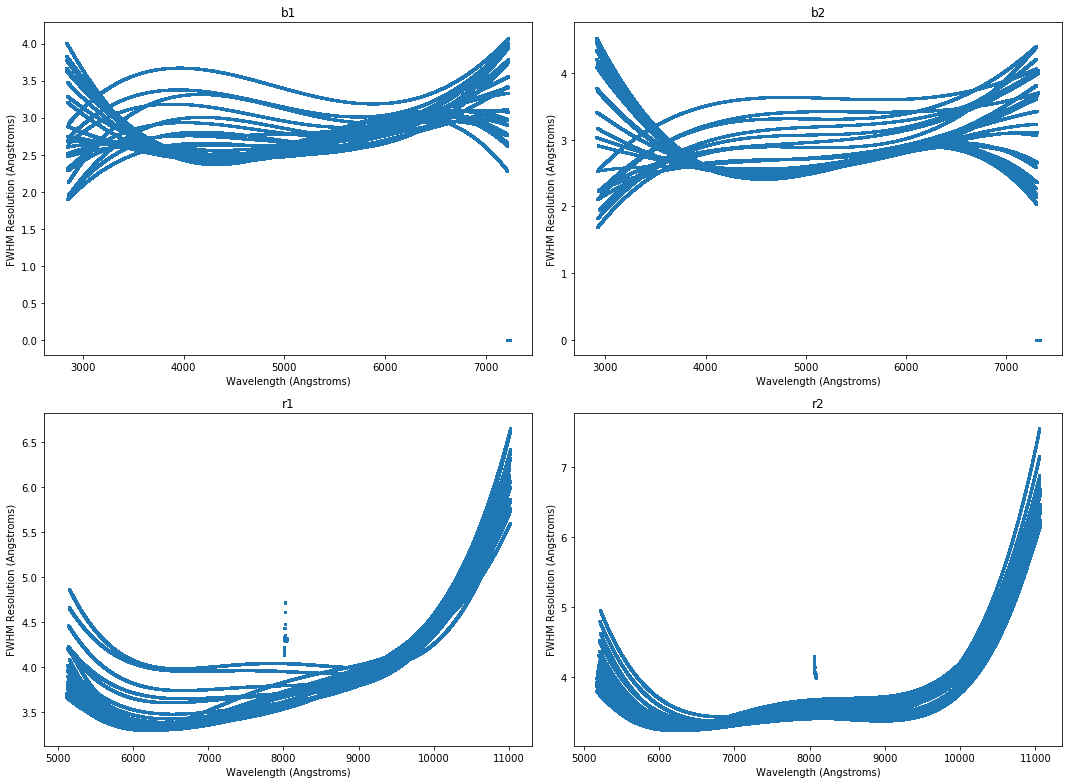

In [286]:
plate = 6641
mjd = 56383
sequence_number = 3

b1_6641, b2_6641, r1_6641, r2_6641 = plot_cameras(plate=plate, mjd=mjd, sequence_number=sequence_number)

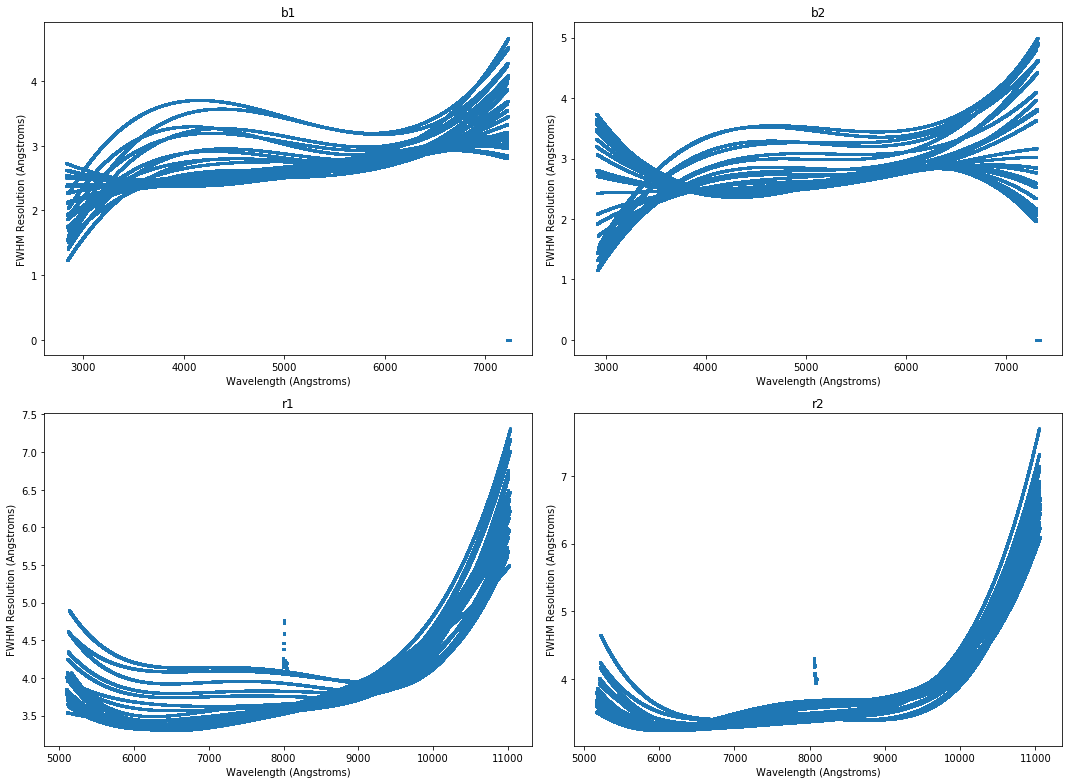

In [327]:
plate = 7426
mjd = 56771
sequence_number = 3

b1_7426, b2_7426, r1_7426, r2_7426 = plot_cameras(plate=plate, mjd=mjd, sequence_number=sequence_number)

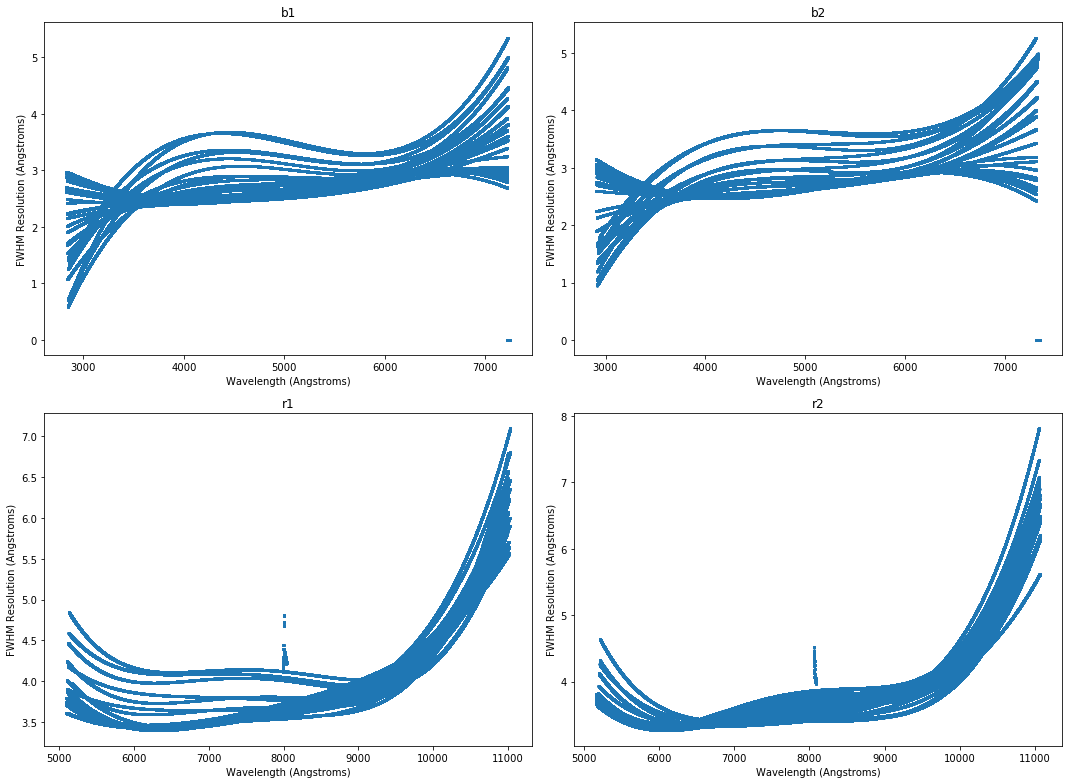

In [299]:
plate = 6963
mjd = 56724
sequence_number = 3

b1_6963, b2_6963, r1_6963, r2_6963 = plot_cameras(plate=plate, mjd=mjd, sequence_number=sequence_number)

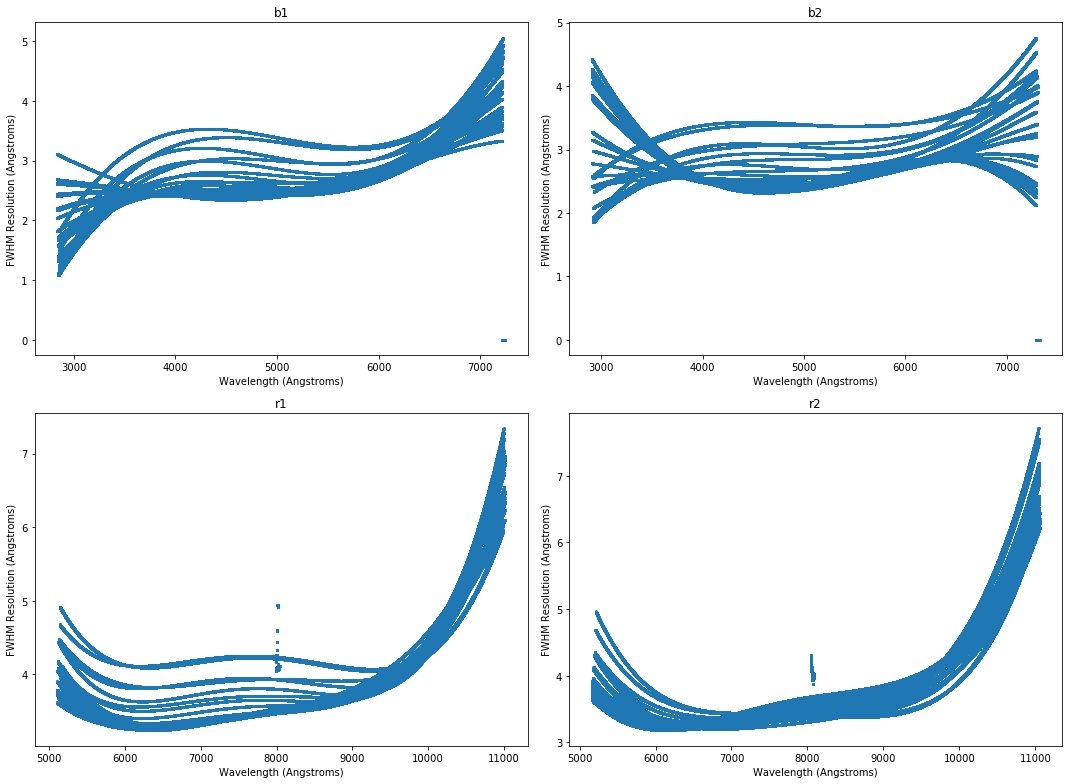

In [300]:
plate = 7027
mjd = 56448
sequence_number = 2

b1_7027, b2_7027, r1_7027, r2_7027 = plot_cameras(plate=plate, mjd=mjd, sequence_number=sequence_number)

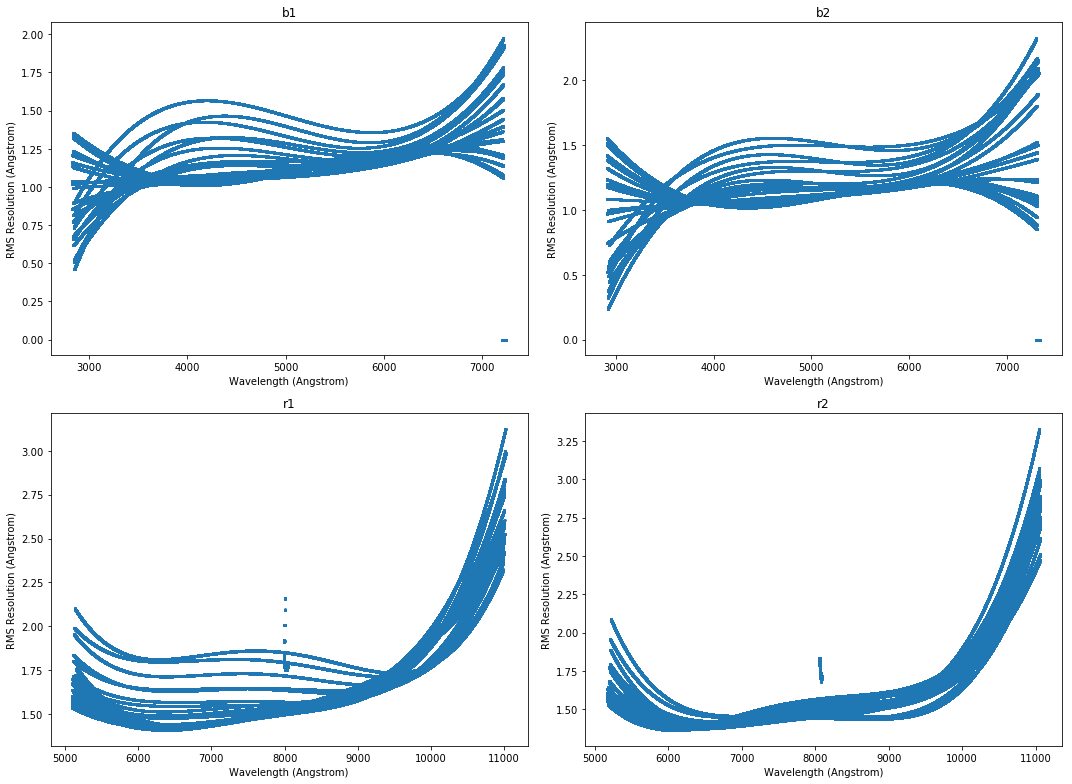

In [107]:
#RMS resolution

plate = 7301
mjd = 56746
sequence_number = 2

b1_7301, b2_7301, r1_7301, r2_7301 = plot_cameras(plate=plate, mjd=mjd, rms=True, sequence_number=sequence_number)

In [17]:
#Test on plate = 7301

wlen = 10**r2_7301[3].data
res = (1/r2_7301[4].data)*fwhm
wlen_range = (wlen > 7900) & (wlen < 8100)
res_range = res < 2.7
bad = wlen_range & res_range

In [32]:
good_pixels = ~bad

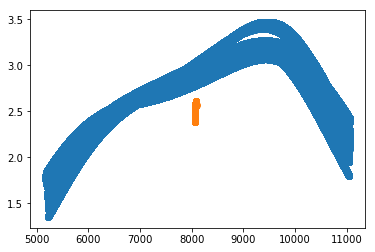

In [91]:
plt.scatter(wlen[~bad], res[~bad])
plt.scatter(wlen[bad], res[bad])

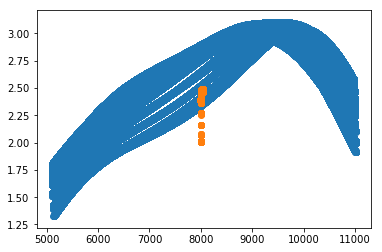

In [93]:
#Test on r1 on same plate
plt.scatter(10**r1_7301[3].data[~bad], ((1/r1_7301[4].data)*fwhm)[~bad])
plt.scatter(10**r1_7301[3].data[bad], ((1/r1_7301[4].data)*fwhm)[bad])

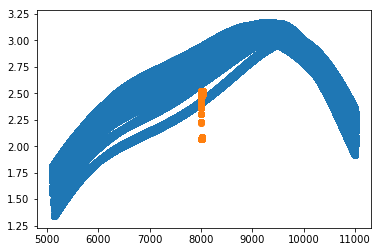

In [94]:
#Test on completely different plate to see whether it's consistent among same indices

plt.scatter(10**r1_7027[3].data[~bad], ((1/r1_7027[4].data)*fwhm)[~bad])
plt.scatter(10**r1_7027[3].data[bad], ((1/r1_7027[4].data)*fwhm)[bad])

In [107]:
#Test on plate = 7027

wlen7027 = 10**r2_7027[3].data
res7027 = (1/r2_7027[4].data)*fwhm
wlen_range7027 = (wlen7027 > 7900) & (wlen7027 < 8100)
res_range7027 = res7027 < 2.7
bad7027 = wlen_range7027 & res_range7027

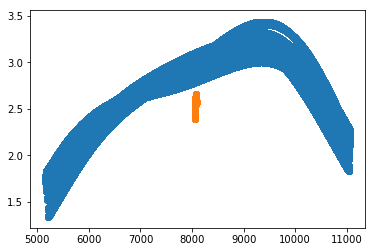

In [108]:
plt.scatter(10**r2_7027[3].data[~bad7027], ((1/r2_7027[4].data)*fwhm)[~bad7027])
plt.scatter(10**r2_7027[3].data[bad7027], ((1/r2_7027[4].data)*fwhm)[bad7027])

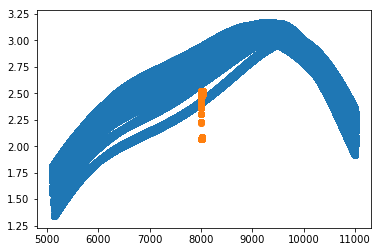

In [109]:
plt.scatter(10**r1_7027[3].data[~bad7027], ((1/r1_7027[4].data)*fwhm)[~bad7027])
plt.scatter(10**r1_7027[3].data[bad7027], ((1/r1_7027[4].data)*fwhm)[bad7027])

In [111]:
np.all(bad == bad7027)

#The artifact can be attributed to a defect in the red ccds

True

http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html

The resolution column is copied from HDU 4 of the spPlate*.fit file. It contains the RMS resolution at each pixel in units of pixels. To get the FWHM resolution, multiply the pixel values by sqrt(8*ln(2)) ∼ 2.35. Since the spectra are binned with constant logarithmic dispersion, the pixel size is fixed in velocity space at 69 km/s = ln(10) * c * 0.0001, where 0.0001 is the log10 dispersion per pixel (stored in the primary header keyword CD1_1). To convert to resolution in wavelength units, multiply by the local pixel size in wavelength units, which is ln(10) * lambda * 0.0001 where lambda is the wavelength of the pixel and 0.0001 is again the log10 dispersion.

### Gather data for each camera over all plates

In [74]:
plates = [7027, 6963, 7301, 6759, 6002, 6178, 6626, 6882, 7389, 7453, 
          7517, 7276, 6390, 6472, 6660, 6877, 6970, 7451, 6122, 6261]
mjds =  [56448, 56724, 56746, 56416, 56104, 56213, 56330, 56541, 56769, 56749, 
         56772, 57061, 56244, 56362, 56370, 56544, 56444, 56739, 56246, 56219]

In [75]:
def combine_cameras(plate, mjd, rms=False):
    
    plate_mjd = zip(plate,mjd)
    
    b1wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b1res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    
    for i, pair in enumerate(plate_mjd):
        b1, b2, r1, r2 = plot_cameras(plate=pair[0], mjd=pair[1], sequence_number=0, 
                                                  plot=False)
                
        b1wlen[i] = 10**b1[3].data
        b2wlen[i] = 10**b2[3].data
        r1wlen[i] = 10**r1[3].data
        r2wlen[i] = 10**r2[3].data

        if rms:
            b1res[i] = b1[4].data*0.0001*np.log(10)*b1wlen[i]
            b2res[i] = b2[4].data*0.0001*np.log(10)*b2wlen[i]
            r1res[i] = r1[4].data*0.0001*np.log(10)*r1wlen[i]
            r2res[i] = r2[4].data*0.0001*np.log(10)*r2wlen[i]
            
        else:
            b1res[i] = b1[4].data*0.0001*np.log(10)*b1wlen[i]*fwhm
            b2res[i] = b2[4].data*0.0001*np.log(10)*b2wlen[i]*fwhm
            r1res[i] = r1[4].data*0.0001*np.log(10)*r1wlen[i]*fwhm
            r2res[i] = r2[4].data*0.0001*np.log(10)*r2wlen[i]*fwhm
                
            
    return(b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res)

In [78]:
b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res = combine_cameras(plates, mjds, rms=True)

## Interpolate resolution on a nominal wavelength grid 

This is so we calcuate the median resolution based on how it scales with wavelength rather than pixel number.

In [13]:
def calculate_wlen_grid(b1wlen, b2wlen,  r1wlen, r2wlen):
    bwlen = np.concatenate((b1wlen, b2wlen), axis=0)
    rwlen = np.concatenate((r1wlen, r2wlen), axis=0)
    return(np.median(bwlen, axis=(0,1)), np.median(rwlen, axis=(0,1)))

In [80]:
bwlen, rwlen = calculate_wlen_grid(b1wlen, b2wlen, r1wlen, r2wlen)

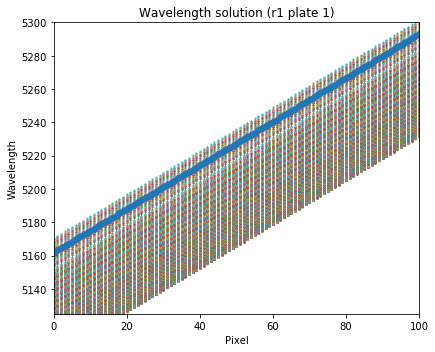

In [345]:
fig = plt.figure(figsize=(6,5))
plt.title('Wavelength solution (r1 plate 1)')
plt.xlabel('Pixel')
plt.ylabel('Wavelength')
plt.tight_layout()

for i in range(500):
    plt.scatter(np.arange(0,4128), r1wlen[0][i], s=1)
plt.scatter(np.arange(0,4128), rwlen)
plt.xlim(0,100)
plt.ylim(5125,5300)
plt.show()

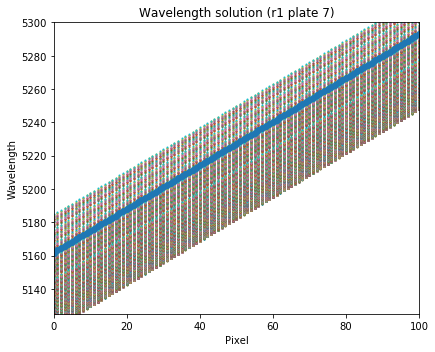

In [317]:
fig = plt.figure(figsize=(6,5))
plt.title('Wavelength solution (r1 plate 7)')
plt.xlabel('Pixel')
plt.ylabel('Wavelength')
plt.tight_layout()

for i in range(500):
    plt.scatter(np.arange(0,4128), r1wlen[7][i], s=1)
plt.scatter(np.arange(0,4128), rwlen)
plt.xlim(0,100)
plt.ylim(5125,5300)
plt.show()

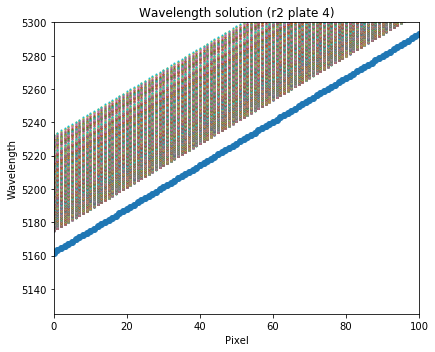

In [318]:
fig = plt.figure(figsize=(6,5))
plt.title('Wavelength solution (r2 plate 4)')
plt.xlabel('Pixel')
plt.ylabel('Wavelength')
plt.tight_layout()

for i in range(500):
    plt.scatter(np.arange(0,4128), r2wlen[4][i], s=1)
plt.scatter(np.arange(0,4128), rwlen)
plt.xlim(0,100)
plt.ylim(5125,5300)
plt.show()

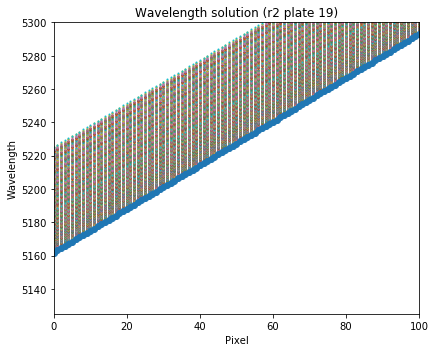

In [319]:
fig = plt.figure(figsize=(6,5))
plt.title('Wavelength solution (r2 plate 19)')
plt.xlabel('Pixel')
plt.ylabel('Wavelength')
plt.tight_layout()

for i in range(500):
    plt.scatter(np.arange(0,4128), r2wlen[19][i], s=1)
plt.scatter(np.arange(0,4128), rwlen)
plt.xlim(0,100)
plt.ylim(5125,5300)
plt.show()

In [122]:
bwlen_concat = np.concatenate((b1wlen, b2wlen), axis=1)
rwlen_concat = np.concatenate((r1wlen, r2wlen), axis=1)
bres_concat = np.concatenate((b1res, b2res), axis=1)
rres_concat = np.concatenate((r1res, r2res), axis=1)

In [26]:
def interp_resolution(bwlen_concat, rwlen_concat, bres_concat, rres_concat, bwlen, rwlen):

    b_res = np.empty((20,1000,3988), dtype=float)
    r_res = np.empty((20,1000,3988), dtype=float)
    
    for plate in range(20):
        for fiber in range(1000):
            b_res[plate, fiber] = np.interp(bwlen[60:-80], bwlen_concat[plate][fiber], bres_concat[plate][fiber])
            r_res[plate, fiber] = np.interp(rwlen[60:-80], rwlen_concat[plate][fiber], rres_concat[plate][fiber])
            
    return(b_res, r_res)

In [123]:
b_res, r_res = interp_resolution(bwlen_concat, rwlen_concat, bres_concat, rres_concat, bwlen, rwlen)
bres_interp, rres_interp = np.median(b_res, axis=(0,1)), np.median(r_res, axis=(0,1))

### Plot overlap of multiple plates for each camera

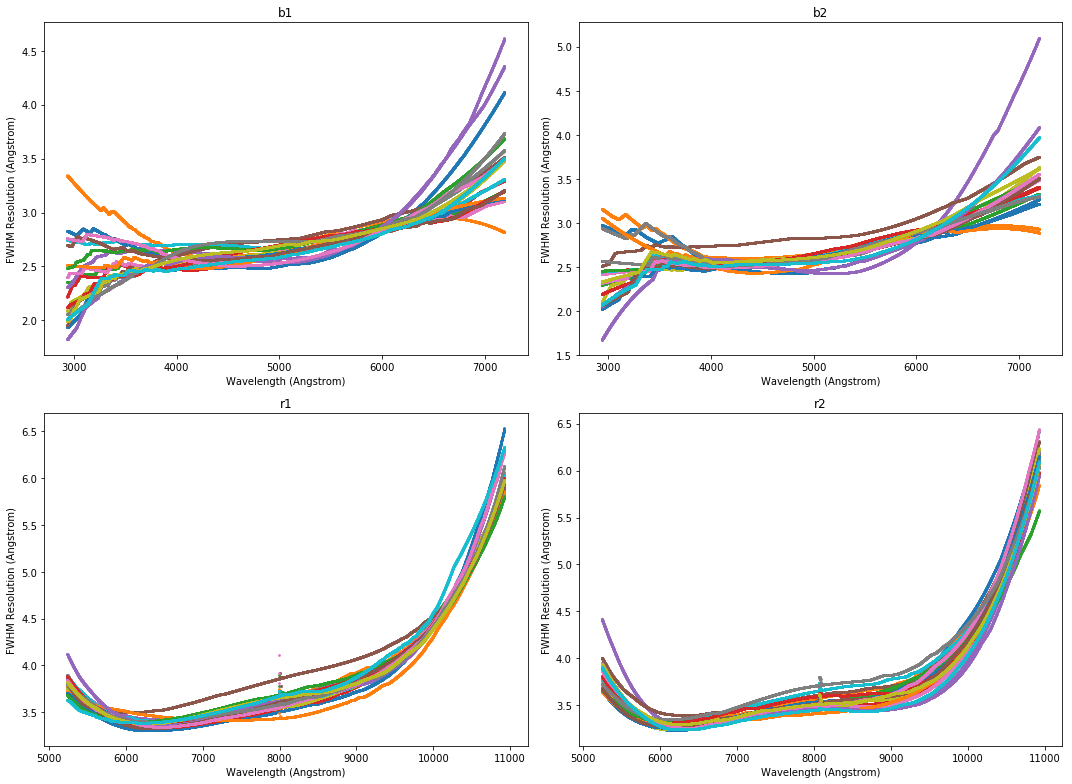

In [28]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 11))
    
fwhm = np.sqrt(8*np.log(2))

for plate in range(20):
    ax1.scatter(bwlen[60:-80], np.median(b_res[plate][:500], axis=0), s=3)
    ax1.set_title('b1')
    ax1.set_ylabel('FWHM Resolution (Angstrom)')
    ax1.set_xlabel('Wavelength (Angstrom)')
    ax2.scatter(bwlen[60:-80], np.median(b_res[plate][500:], axis=0), s=3)
    ax2.set_title('b2')
    ax2.set_ylabel('FWHM Resolution (Angstrom)')
    ax2.set_xlabel('Wavelength (Angstrom)')
    ax3.scatter(rwlen[60:-80], np.median(r_res[plate][:500], axis=0), s=3)
    ax3.set_title('r1')
    ax3.set_ylabel('FWHM Resolution (Angstrom)')
    ax3.set_xlabel('Wavelength (Angstrom)')
    ax4.scatter(rwlen[60:-80], np.median(r_res[plate][500:], axis=0), s=3)
    ax4.set_title('r2')
    ax4.set_ylabel('FWHM Resolution (Angstrom)')
    ax4.set_xlabel('Wavelength (Angstrom)')

plt.tight_layout()
#plt.savefig('multiple_plates.png')

## Median of interpolated resolution values on wavelength grid

### Blue Camera

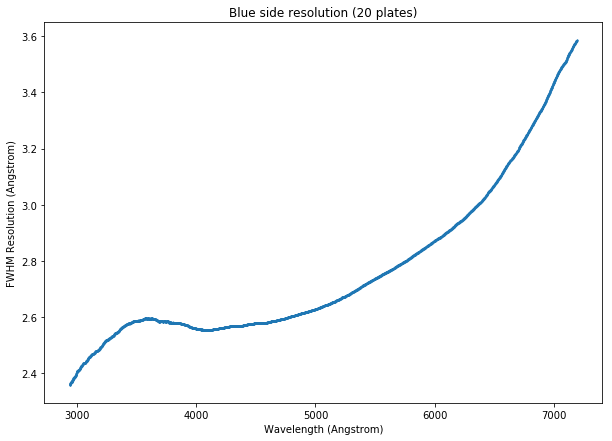

In [378]:
plt.figure(figsize=(10,7))
plt.scatter(bwlen[60:-80], bres_interp, s=1)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('FWHM Resolution (Angstrom)')
plt.title('Blue side resolution (20 plates)')
plt.savefig('blue_res.png')
plt.show()

### Red Camera

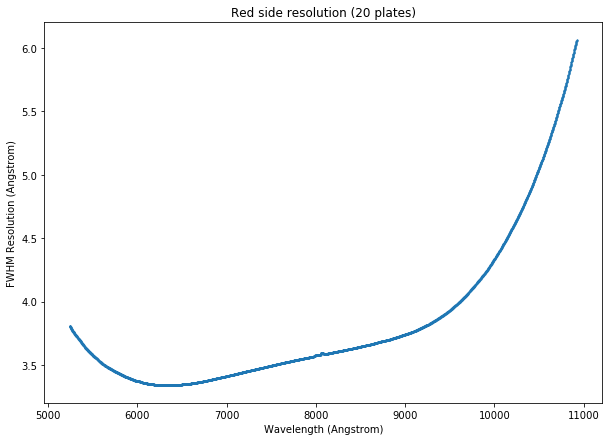

In [377]:
plt.figure(figsize=(10,7))
plt.scatter(rwlen[60:-80], rres_interp, s=1)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('FWHM Resolution (Angstrom)')
plt.title('Red side resolution (20 plates)')
plt.savefig('red_res.png')
plt.show()

## Row Size

In [29]:
def plot_row_width(plate, mjd, sequence_number=1, plot=True):
    plan_path = finder.get_plate_plan_path(plate=plate, mjd=mjd, combined=True)
    b1_hdulist, b1_title = get_hdulist(sequence_number=sequence_number, band='blue', fiber=30, plan_path=plan_path)
    b2_hdulist, b2_title = get_hdulist(sequence_number=sequence_number, band='blue', fiber=600, plan_path=plan_path)
    r1_hdulist, r1_title = get_hdulist(sequence_number=sequence_number, band='red', fiber=30, plan_path=plan_path)
    r2_hdulist, r2_title = get_hdulist(sequence_number=sequence_number, band='red', fiber=600, plan_path=plan_path)
    if plot:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 11))
        b1_w = 10**b1_hdulist[3].data
        b1_r = np.gradient(b1_w, axis=1)
        b2_w = 10**b2_hdulist[3].data
        b2_r = np.gradient(b2_w, axis=1)
        r1_w = 10**r1_hdulist[3].data
        r1_r = np.gradient(r1_w, axis=1)
        r2_w = 10**r2_hdulist[3].data
        r2_r = np.gradient(r2_w, axis=1)
        
        ax1.scatter(b1_w, b1_r, s=3)
        ax2.scatter(b2_w, b2_r, s=3)
        ax3.scatter(r1_w, r1_r, s=3)
        ax4.scatter(r2_w, r2_r, s=3)
        
        ax1.set_title('{:s}'.format(b1_title))
        ax1.set_xlabel('Wavelength (Angstrom)')
        ax1.set_ylabel('FWHM Resolution (Angstrom)')
        ax2.set_title('{:s}'.format(b2_title))
        ax2.set_xlabel('Wavelength (Angstrom)')
        ax2.set_ylabel('FWHM Resolution (Angstrom)')
        ax3.set_title('{:s}'.format(r1_title))
        ax3.set_xlabel('Wavelength (Angstrom)')
        ax3.set_ylabel('FWHM Resolution (Angstrom)')
        ax4.set_title('{:s}'.format(r2_title))
        ax4.set_xlabel('Wavelength (Angstrom)')
        ax4.set_ylabel('FWHM Resolution (Angstrom)')
        
        
        plt.tight_layout()
        #plt.savefig('plate7301_mjd56746.png')
        plt.show()
        
    return b1_hdulist, b2_hdulist, r1_hdulist, r2_hdulist

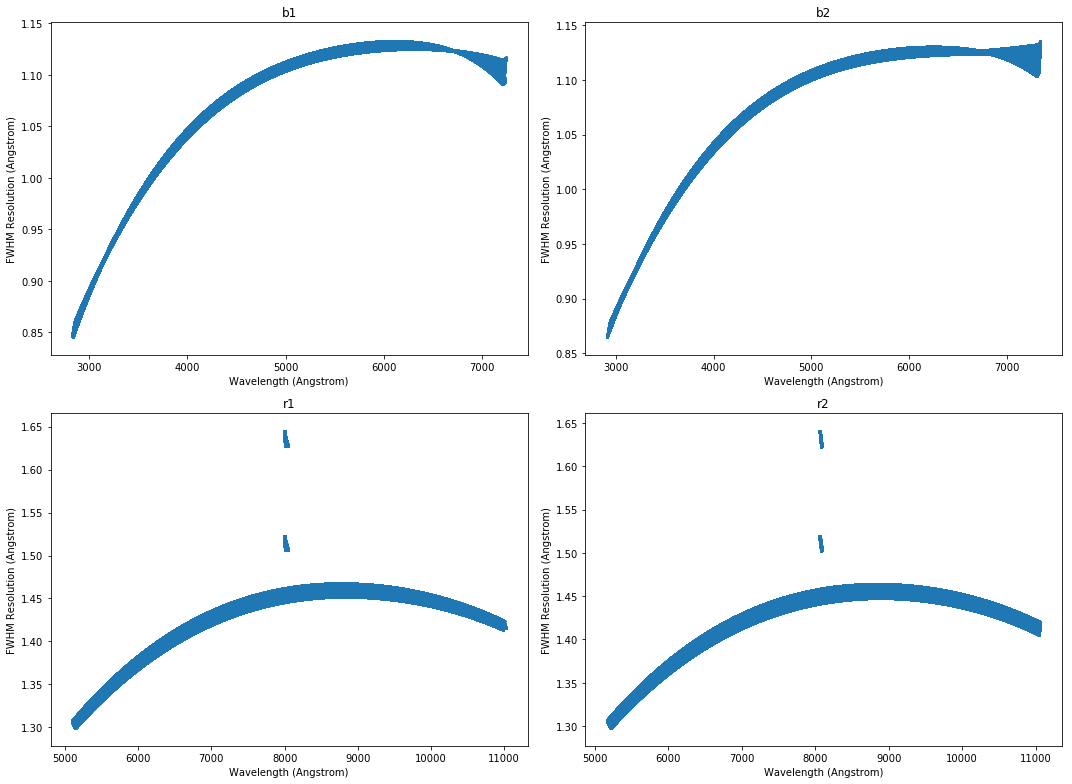

In [12]:
plate = 7301
mjd = 56746
sequence_number = 2

b1_7301, b2_7301, r1_7301, r2_7301 = plot_row_width(plate=plate, mjd=mjd, sequence_number=sequence_number)

In [33]:
def combine_cameras_row_width(plate, mjd):
    
    plate_mjd = zip(plate,mjd)
    
    b1wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b1res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    
    for i, pair in enumerate(plate_mjd):
        b1, b2, r1, r2 = plot_cameras(plate=pair[0], mjd=pair[1], sequence_number=0, 
                                                  plot=False)
                
        b1wlen[i] = 10**b1[3].data
        b2wlen[i] = 10**b2[3].data
        r1wlen[i] = 10**r1[3].data
        r2wlen[i] = 10**r2[3].data


        
        b1res[i] = np.gradient(b1wlen[i], axis=1)
        b2res[i] = np.gradient(b2wlen[i], axis=1)
        r1res[i] = np.gradient(r1wlen[i], axis=1)
        r2res[i] = np.gradient(r2wlen[i], axis=1)
                
            
    return(b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res)

In [34]:
b1wlen, b2wlen, r1wlen, r2wlen, b1width, b2width, r1width, r2width = combine_cameras_row_width(plates, mjds)

In [35]:
bwlen, rwlen = calculate_wlen_grid(b1wlen, b2wlen, r1wlen, r2wlen)

In [36]:
bwlen_concat = np.concatenate((b1wlen, b2wlen), axis=1)
rwlen_concat = np.concatenate((r1wlen, r2wlen), axis=1)
bwidth_concat = np.concatenate((b1width, b2width), axis=1)
rwidth_concat = np.concatenate((r1width, r2width), axis=1)

In [39]:
b_width, r_width = interp_resolution(bwlen_concat, rwlen_concat, bwidth_concat, rwidth_concat, bwlen, rwlen)
bwidth_interp, rwidth_interp = np.median(b_width, axis=(0,1)), np.median(r_width, axis=(0,1))

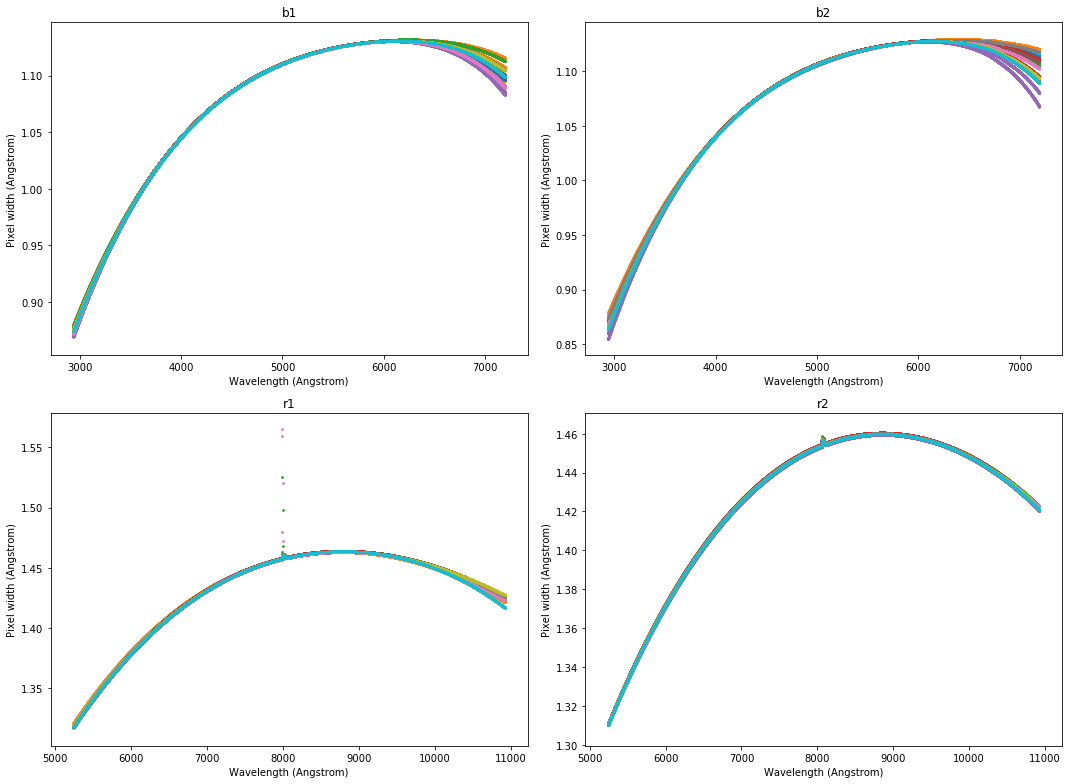

In [42]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15, 11))
    
fwhm = np.sqrt(8*np.log(2))

for plate in range(20):
    ax1.scatter(bwlen[60:-80], np.median(b_width[plate][:500], axis=0), s=3)
    ax1.set_title('b1')
    ax1.set_ylabel('Pixel width (Angstrom)')
    ax1.set_xlabel('Wavelength (Angstrom)')
    ax2.scatter(bwlen[60:-80], np.median(b_width[plate][500:], axis=0), s=3)
    ax2.set_title('b2')
    ax2.set_ylabel('Pixel width (Angstrom)')
    ax2.set_xlabel('Wavelength (Angstrom)')
    ax3.scatter(rwlen[60:-80], np.median(r_width[plate][:500], axis=0), s=3)
    ax3.set_title('r1')
    ax3.set_ylabel('Pixel width (Angstrom)')
    ax3.set_xlabel('Wavelength (Angstrom)')
    ax4.scatter(rwlen[60:-80], np.median(r_width[plate][500:], axis=0), s=3)
    ax4.set_title('r2')
    ax4.set_ylabel('Pixel width (Angstrom)')
    ax4.set_xlabel('Wavelength (Angstrom)')
    
#plt.savefig('multiple_plates_row_size.png')
plt.tight_layout()

## Median of interpolated resolution values on wavelength grid

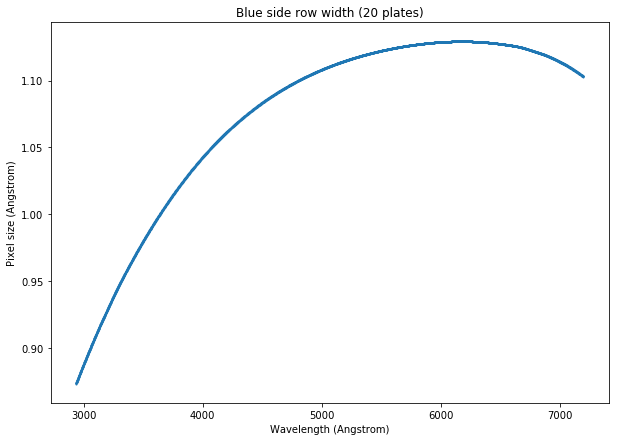

In [43]:
plt.figure(figsize=(10,7))
plt.scatter(bwlen[60:-80], bwidth_interp, s=1)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Pixel size (Angstrom)')
plt.title('Blue side row width (20 plates)')
plt.savefig('blue_width.png')
plt.show()

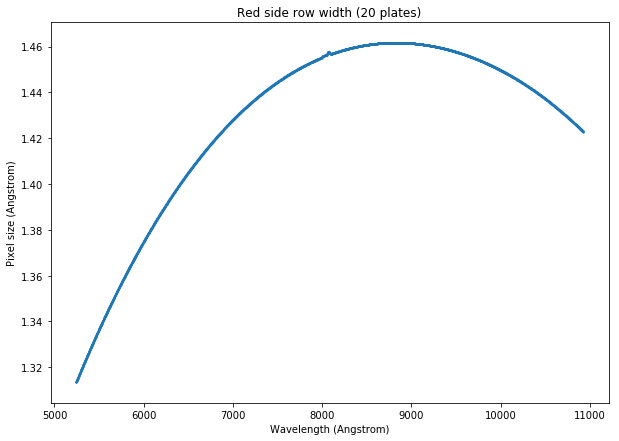

In [44]:
plt.figure(figsize=(10,7))
plt.scatter(rwlen[60:-80], rwidth_interp, s=1)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('Pixel size (Angstrom)')
plt.title('Red side row width (20 plates)')
plt.savefig('red_width.png')
plt.show()

## Compare w/ DESI Configuration

In [180]:
psf_hdu = fits.open('psf-quicksim.fits')
psf_hdu[3].data

FITS_rec([( 7435. ,  1.91628136,  2.939514  ,  4.24979422,  0.64895353),
       ( 7435.5,  1.91625612,  2.9393808 ,  4.24948745,  0.64894197),
       ( 7436. ,  1.91619671,  2.93924778,  4.24918106,  0.64891886), ...,
       ( 9833. ,  1.89991708,  3.05077968,  4.48093781,  0.54554111),
       ( 9833.5,  1.89999675,  3.05108448,  4.48154661,  0.54552019),
       ( 9834. ,  1.90011289,  3.05138957,  4.48215582,  0.54550973)], 
      dtype=(numpy.record, [('wavelength', '>f8'), ('fwhm_wave', '>f8'), ('fwhm_spatial', '>f8'), ('neff_spatial', '>f8'), ('angstroms_per_row', '>f8')]))

In [182]:
psf_hdu[1].data['wavelength'].shape
len(bwlen)

4128

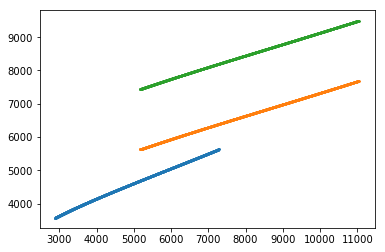

In [191]:
plt.scatter(bwlen, psf_hdu[1].data['wavelength'][:4128], s=1)
plt.scatter(rwlen, psf_hdu[2].data['wavelength'][:4128], s=1)
plt.scatter(rwlen, psf_hdu[3].data['wavelength'][:4128], s=1)
#plt.plot(np.arange(0, len(bwlen)), bwlen, c='b')
plt.show()

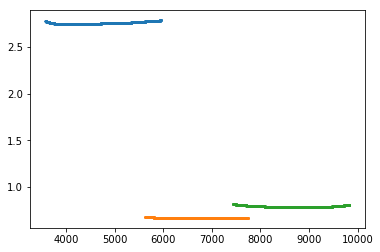

In [202]:
plt.scatter(psf_hdu[1].data['wavelength'], psf_hdu[1].data['fwhm_spatial'], s=1)
plt.scatter(psf_hdu[2].data['wavelength'], psf_hdu[2].data['fwhm_wave']/fwhm, s=1)
plt.scatter(psf_hdu[3].data['wavelength'], psf_hdu[3].data['fwhm_wave']/fwhm, s=1)
plt.show()

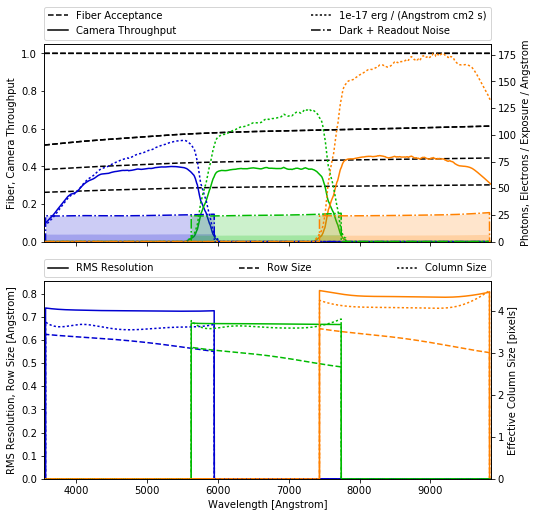

In [58]:
config = config.load_config('desi')
instrument.initialize(config).plot()

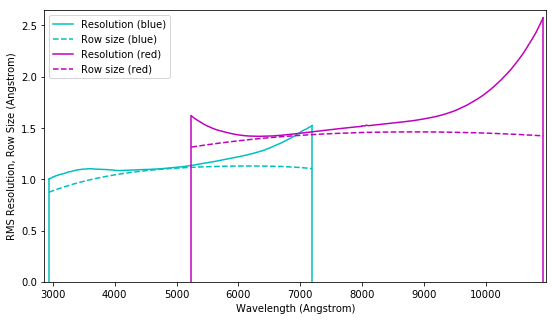

In [132]:
fig = plt.figure(figsize=(9, 5))
#wavelength resolution -- blue
plt.plot(bwlen[60:-80], bres_interp, c='c', label='Resolution (blue)')
plt.plot((bwlen[60], bwlen[60]), (0, bres_interp[0]), c='c')
plt.plot((bwlen[-80], bwlen[-80]), (0, bres_interp[-1]), c='c')

#row size -- blue
plt.plot(bwlen[60:-80], bwidth_interp, c='c', ls='--', label='Row size (blue)')

#wavelength resolution -- red
plt.plot(rwlen[60:-80], rres_interp, c='m', label='Resolution (red)')
plt.plot((rwlen[60], rwlen[60]), (0, rres_interp[0]), c='m')
plt.plot((rwlen[-80], rwlen[-80]), (0, rres_interp[-1]), c='m')


#row size -- red
plt.plot(rwlen[60:-80], rwidth_interp, c='m', ls='--', label='Row size (red)')

plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('RMS Resolution, Row Size (Angstrom)')
plt.xlim(bwlen[60]-75,rwlen[-80]+50)
plt.ylim(0,2.65)
plt.legend()
#plt.savefig('instrument_config_rms.png')
plt.show()

## neff

https://data.sdss.org/datamodel/files/BOSS_SPECTRO_REDUX/RUN2D/PLATE4/spFlat.html

In [10]:
def plot_neff(plate, mjd, fiber, plot=True):
    
    remote_plate_spec_path = finder.get_plate_spec_path(plate=plate, mjd=mjd)
    plate_spec_path = mirror.get(remote_plate_spec_path)
    PlateFile = bossdata.plate.PlateFile(plate_spec_path)    
    
    exp_nameb1 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='b1', 
                                                     ftype='spFlat')
    exp_nameb2 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='b2', 
                                                     ftype='spFlat')
    exp_namer1 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='r1', 
                                                     ftype='spFlat')
    exp_namer2 = PlateFile.exposures.get_exposure_name(exposure_index=1, camera='r2', 
                                                     ftype='spFlat')

    remote_plate_path_b1 = finder.get_plate_path(plate=plate, filename=exp_nameb1)
    remote_plate_path_b2 = finder.get_plate_path(plate=plate, filename=exp_nameb2)
    remote_plate_path_r1 = finder.get_plate_path(plate=plate, filename=exp_namer1)
    remote_plate_path_r2 = finder.get_plate_path(plate=plate, filename=exp_namer2)
    
    plate_path_b1 = mirror.get(remote_plate_path_b1)
    plate_path_b2 = mirror.get(remote_plate_path_b2)
    plate_path_r1 = mirror.get(remote_plate_path_r1)
    plate_path_r2 = mirror.get(remote_plate_path_r2)

    hdulist_b1 = fitsio.FITS(plate_path_b1, mode=fitsio.READONLY)
    hdulist_b2 = fitsio.FITS(plate_path_b2, mode=fitsio.READONLY)
    hdulist_r1 = fitsio.FITS(plate_path_r1, mode=fitsio.READONLY)
    hdulist_r2 = fitsio.FITS(plate_path_r2, mode=fitsio.READONLY)
    
    TraceSet_b1 = bossdata.plate.TraceSet(hdulist_b1[3])
    TraceSet_b2 = bossdata.plate.TraceSet(hdulist_b2[3])
    TraceSet_r1 = bossdata.plate.TraceSet(hdulist_r1[3])
    TraceSet_r2 = bossdata.plate.TraceSet(hdulist_r2[3])

    if plot:

        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,7), sharex=True)
        
        ax1.plot(TraceSet_b1.get_y()[fiber], 'o')
        ax1.set_title('b1')
        ax1.set_ylabel('Pixel')
        ax2.plot(TraceSet_b2.get_y()[fiber], 'o')
        ax2.set_title('b2')
        ax3.plot(TraceSet_r1.get_y()[fiber], 'o')
        ax3.set_title('r1')
        ax3.set_xlabel('Pixel')
        ax3.set_ylabel('Pixel')
        ax4.plot(TraceSet_r2.get_y()[fiber], 'o')
        ax4.set_title('r2')
        ax4.set_xlabel('Pixel')

        plt.tight_layout()
        plt.show()
    
    return TraceSet_b1, TraceSet_b2, TraceSet_r1, TraceSet_r2

## plate 7027, mjd 56448

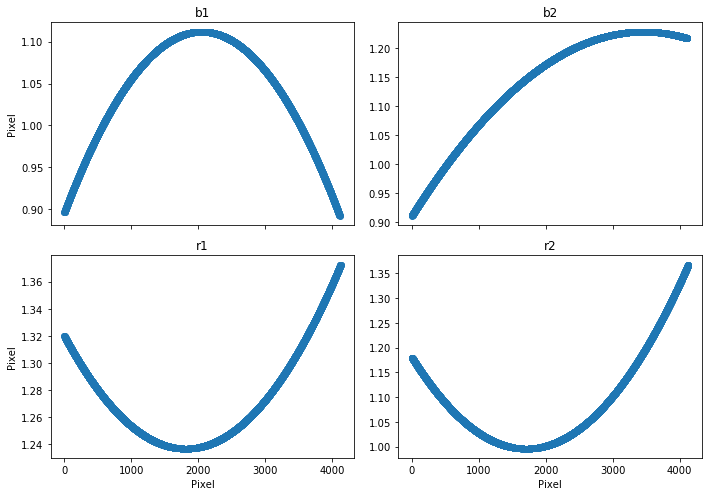

In [160]:
b1, b2, r1, r2 = plot_neff(plate=plates[0], mjd=mjds[0], fiber=0)

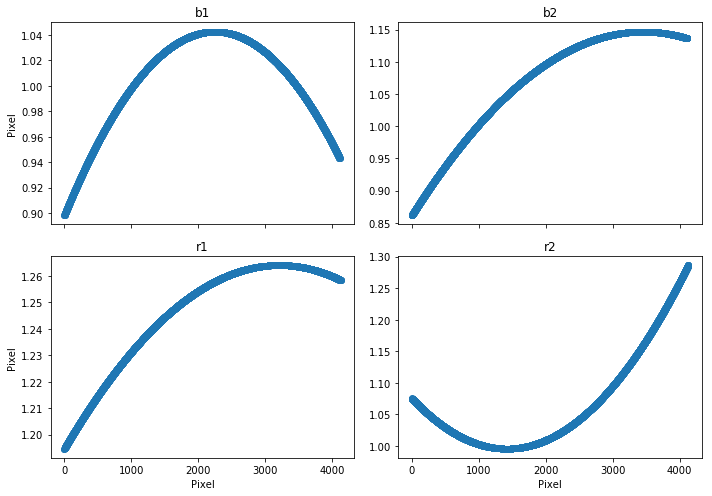

In [91]:
b1, b2, r1, r2 = plot_neff(plate=plates[0], mjd=mjds[0], fiber=20)

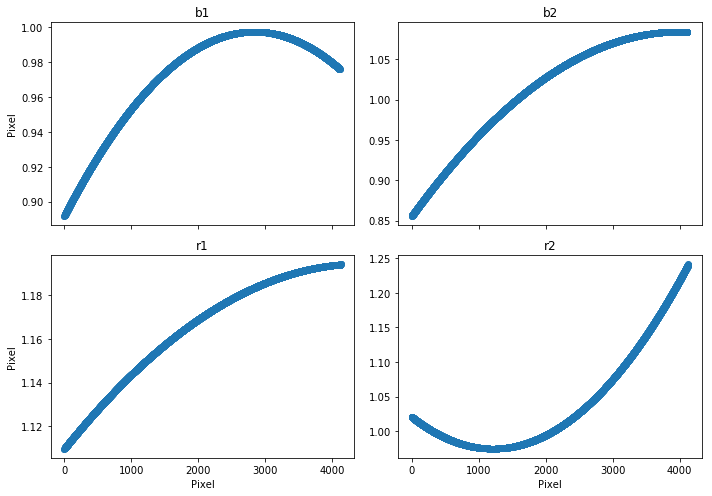

In [37]:
plot_neff(plate=plates[0], mjd=mjds[0], fiber=50)

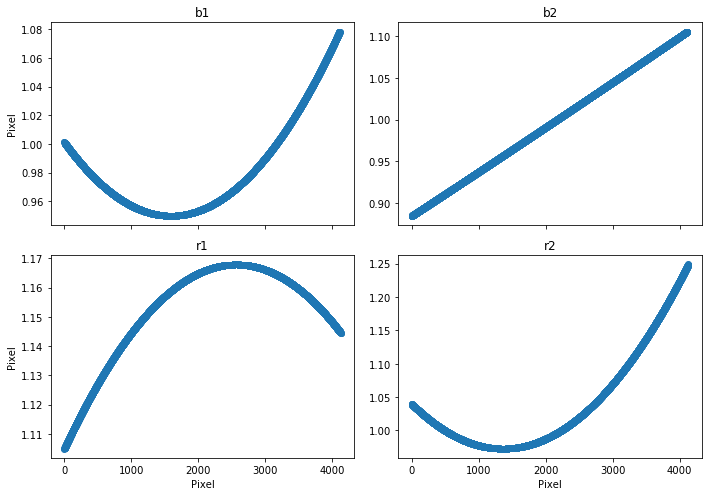

In [38]:
plot_neff(plate=plates[0], mjd=mjds[0], fiber=75)

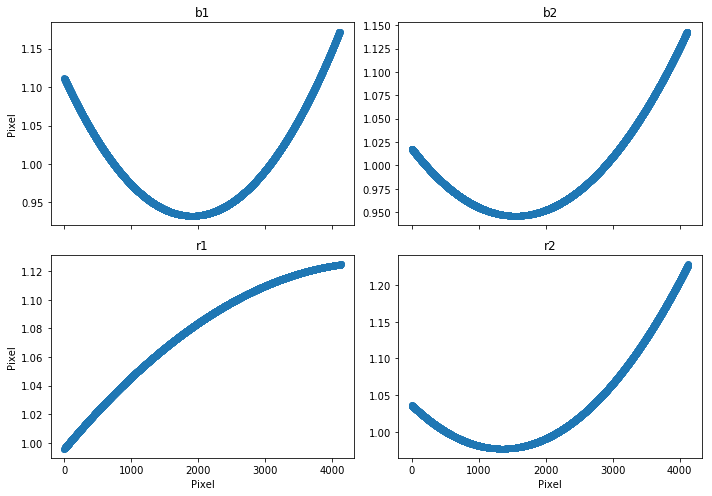

In [39]:
plot_neff(plate=plates[0], mjd=mjds[0], fiber=100)

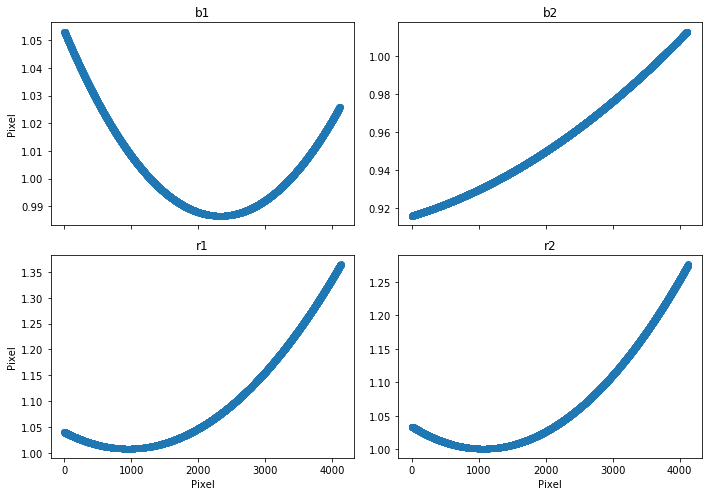

In [40]:
plot_neff(plate=plates[0], mjd=mjds[0], fiber=400)

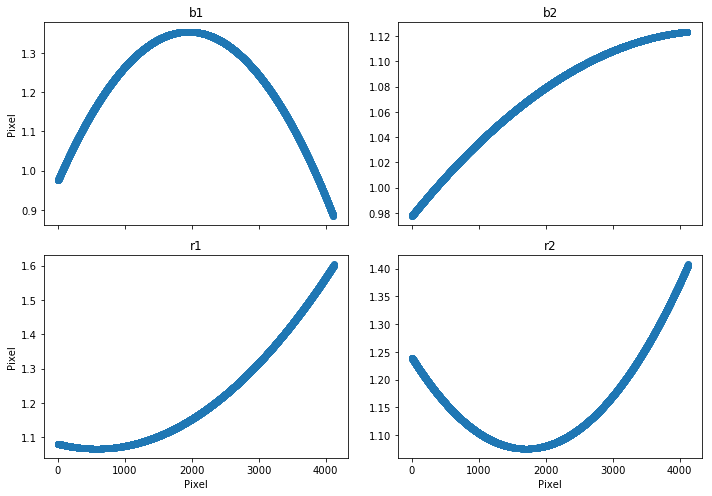

In [41]:
plot_neff(plate=plates[0], mjd=mjds[0], fiber=499)

#### Fibers are bundled in groups of 20

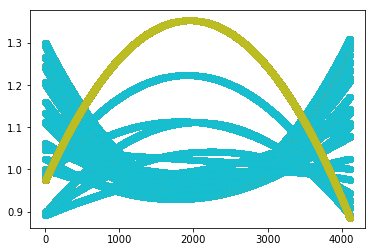

((4112,), (4112,), (4128,), (4128,))


In [94]:
#color-code by fiber bundle (every 20 fibers)

for i in range(499):
    b1, b2, r1, r2 = plot_neff(plate=plates[0], mjd=mjds[0], fiber=i, plot=False)
    plt.plot(b1, 'o')
plt.show()
print(b1.shape, b2.shape, r1.shape, r2.shape)

In [82]:
# blue cameras have length 4112, red have 4128

In [81]:
bwlen.shape, rwlen.shape

((4128,), (4128,))

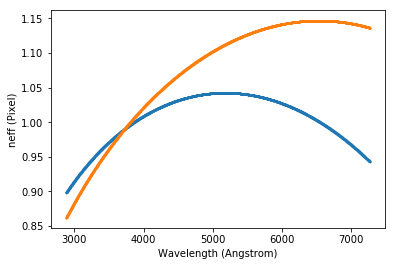

In [92]:
plt.scatter(bwlen[:4112], b1, s=1)
plt.scatter(bwlen[:4112], b2, s=1)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('neff (Pixel)')
plt.show()

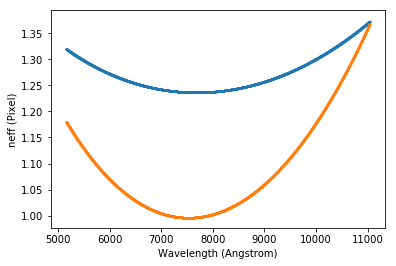

In [111]:
plt.scatter(rwlen, r1, s=1)
plt.scatter(rwlen, r2, s=1)
plt.xlabel('Wavelength (Angstrom)')
plt.ylabel('neff (Pixel)')
plt.show()

In [ ]:
#for interpolation, use same nominal wlen grid, and same concatenated wavelength soln as above
#is it ok to cut off last 16 pixels on blue sides?

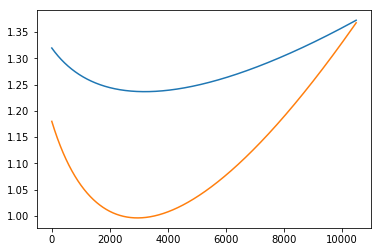

In [112]:
plt.plot(np.arange(0,4128)*0.0001*np.log(10)*rwlen, r1)
plt.plot(np.arange(0,4128)*0.0001*np.log(10)*rwlen, r2)

In [97]:
rwlen

array([  5161.80832153,   5163.11280622,   5164.41771707, ...,
        11034.30246311,  11035.71442276,  11037.12633174])

In [102]:
b1hdu, b2hdu, r1hdu, r2hdu = plot_cameras(plates[0], mjds[0], sequence_number=1, rms=False, plot=False)

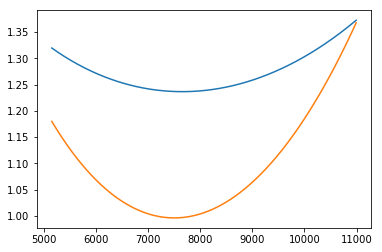

In [113]:
plt.plot(10**r1hdu[3].data[0], r1)
plt.plot(10**r1hdu[3].data[0], r2)

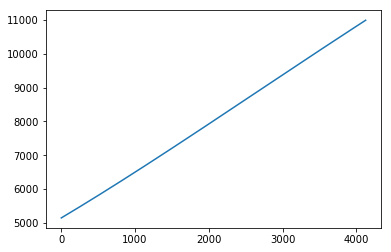

In [114]:
plt.plot(np.arange(0,4128), 10**r1hdu[3].data[0])

## Compute all at once

In [8]:
def combine(plate, mjd, fwhm=True):
    
    plate_mjd = zip(plate,mjd)
    
    b1neff = np.empty((len(plate_mjd), 500, 4112), dtype=float)
    b2neff = np.empty((len(plate_mjd), 500, 4112), dtype=float)
    r1neff = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2neff = np.empty((len(plate_mjd), 500, 4128), dtype=float)        

    b1wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2wlen = np.empty((len(plate_mjd), 500, 4128), dtype=float)

    b1res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1res = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2res = np.empty((len(plate_mjd), 500, 4128), dtype=float)

    b1width = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    b2width = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r1width = np.empty((len(plate_mjd), 500, 4128), dtype=float)
    r2width = np.empty((len(plate_mjd), 500, 4128), dtype=float)
        
    
    
    for i, pair in enumerate(plate_mjd):
        
            
        b1TraceSet, b2TraceSet, r1TraceSet, r2TraceSet = plot_neff(plate=pair[0], 
                    mjd=pair[1], fiber=0, plot=False)

        b1neff[i] = b1TraceSet.get_y()
        b2neff[i] = b2TraceSet.get_y()
        r1neff[i] = r1TraceSet.get_y()
        r2neff[i] = r2TraceSet.get_y()
        
        
            
        b1, b2, r1, r2 = plot_cameras(plate=pair[0], mjd=pair[1], sequence_number=0, 
                                                  plot=False)
        
        b1wlen[i] = 10**b1[3].data
        b2wlen[i] = 10**b2[3].data
        r1wlen[i] = 10**r1[3].data
        r2wlen[i] = 10**r2[3].data
            

        
        b1width[i] = np.gradient(b1wlen[i], axis=1)
        b2width[i] = np.gradient(b2wlen[i], axis=1)
        r1width[i] = np.gradient(r1wlen[i], axis=1)
        r2width[i] = np.gradient(r2wlen[i], axis=1)

                
        b1res[i] = b1[4].data*0.0001*np.log(10)*b1wlen[i]
        b2res[i] = b2[4].data*0.0001*np.log(10)*b2wlen[i]
        r1res[i] = r1[4].data*0.0001*np.log(10)*r1wlen[i]
        r2res[i] = r2[4].data*0.0001*np.log(10)*r2wlen[i]
                
        if fwhm:
        
            b1res[i] = b1res[i]*fwhm
            b2res[i] = b2res[i]*fwhm
            r1res[i] = r1res[i]*fwhm
            r2res[i] = r2res[i]*fwhm
                
                
    return(b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res, 
           b1width, b2width, r1width, r2width, b1neff, b2neff, r1neff, r2neff)

In [11]:
b1wlen, b2wlen, r1wlen, r2wlen, b1res, b2res, r1res, r2res, b1width, b2width, r1width, r2width, b1neff, b2neff, r1neff, r2neff = combine(plate=plates, mjd=mjds)

In [14]:
bwlen, rwlen = calculate_wlen_grid(b1wlen, b2wlen, r1wlen, r2wlen)

In [15]:
bwlen_concat = np.concatenate((b1wlen, b2wlen), axis=1)
rwlen_concat = np.concatenate((r1wlen, r2wlen), axis=1)
bres_concat = np.concatenate((b1res, b2res), axis=1)
rres_concat = np.concatenate((r1res, r2res), axis=1)
bwidth_concat = np.concatenate((b1width, b2width), axis=1)
rwidth_concat = np.concatenate((r1width, r2width), axis=1)
bneff_concat = np.concatenate((b1neff, b2neff), axis=1)
rneff_concat = np.concatenate((r1neff, r2neff), axis=1)

In [215]:
bwlen_concat[0][1][:4112].shape, bneff_concat[0][1].shape

((4112,), (4112,))

In [16]:
def interpolate(bx, rx, bxp, rxp, bfp, rfp, neff=False):

    b_interp = np.empty((20,1000,3988), dtype=float)
    r_interp = np.empty((20,1000,3988), dtype=float)
    
    if neff:
        for plate in range(20):
            for fiber in range(1000):
                b_interp[plate, fiber] = np.interp(bx[60:-80], bxp[plate][fiber][:4112], bfp[plate][fiber])
                r_interp[plate, fiber] = np.interp(rx[60:-80], rxp[plate][fiber], rfp[plate][fiber])
    
    else:
        for plate in range(20):
            for fiber in range(1000):
                b_interp[plate, fiber] = np.interp(bx[60:-80], bxp[plate][fiber], bfp[plate][fiber])
                r_interp[plate, fiber] = np.interp(rx[60:-80], rxp[plate][fiber], rfp[plate][fiber])
            
    return(b_interp, r_interp)

In [17]:
b_width_interp, r_width_interp = interpolate(bwlen, rwlen, bwlen_concat, rwlen_concat, bwidth_concat, rwidth_concat)
b_res_interp, r_res_interp = interpolate(bwlen, rwlen, bwlen_concat, rwlen_concat, bres_concat, rres_concat)
b_neff_interp, r_neff_interp = interpolate(bwlen, rwlen, bwlen_concat, rwlen_concat, bneff_concat, rneff_concat, neff=True)

#### Take median of each interpolated vector

In [18]:
bwidth_median = np.median(b_width_interp, axis=(0,1))
rwidth_median = np.median(r_width_interp, axis=(0,1))
bres_median = np.median(b_res_interp, axis=(0,1))
rres_median = np.median(r_res_interp, axis=(0,1))
bneff_median = np.median(b_neff_interp, axis=(0,1))
rneff_median = np.median(r_neff_interp, axis=(0,1))

### Plot results

#### Row size

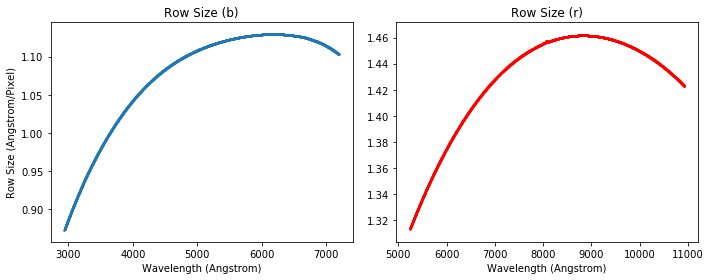

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(bwlen[60:-80], bwidth_median, s=1)
ax2.scatter(rwlen[60:-80], rwidth_median, s=1, c='r')

ax1.set_title('Row Size (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('Row Size (Angstrom/Pixel)')
ax2.set_title('Row Size (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
plt.tight_layout()
plt.show()

#### Resolution

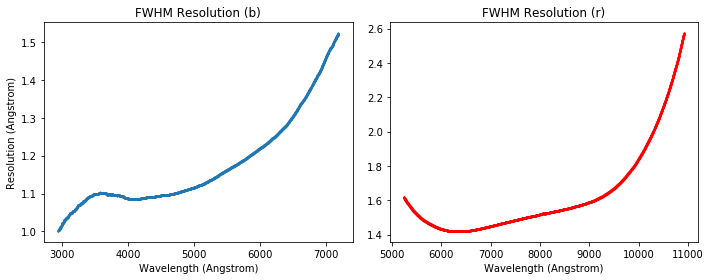

In [277]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(bwlen[60:-80], bres_median, s=1)
ax2.scatter(rwlen[60:-80], rres_median, s=1, c='r')

ax1.set_title('FWHM Resolution (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('Resolution (Angstrom)')
ax2.set_title('FWHM Resolution (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
plt.tight_layout()
plt.show()

#### neff/profile width

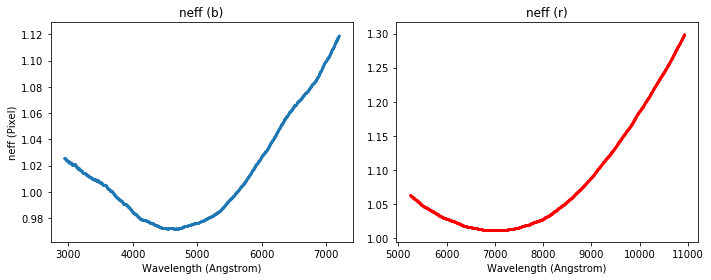

In [278]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(bwlen[60:-80], bneff_median, s=1)
ax2.scatter(rwlen[60:-80], rneff_median, s=1, c='r')

ax1.set_title('neff (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('neff (Pixel)')
ax2.set_title('neff (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
plt.tight_layout()
plt.show()

***Note: didn't get rid of artifact in red ccds at around 8000 Angstroms

## Compare to DESI configuration

In [239]:
!ls

DECalS Sky Brightness.ipynb psf-quicksim.fits
Figures                     sky.fits
SDSS Sky Brightness.ipynb   test_eboss_config.ipynb
Telecon                     test_flats.ipynb
Telescope Notes.pages       wlen_res.ipynb
boss-summary.dat


In [241]:
desi_hdulist = fitsio.FITS('psf-quicksim.fits', mode=fitsio.READONLY)

In [259]:
desi_hdulist


  file: psf-quicksim.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       
  1      BINARY_TBL      QUICKSIM-B
  2      BINARY_TBL      QUICKSIM-R
  3      BINARY_TBL      QUICKSIM-Z

In [260]:
quicksim_b = desi_hdulist[1].read()
quicksim_r = desi_hdulist[2].read()
quicksim_z = desi_hdulist[3].read()

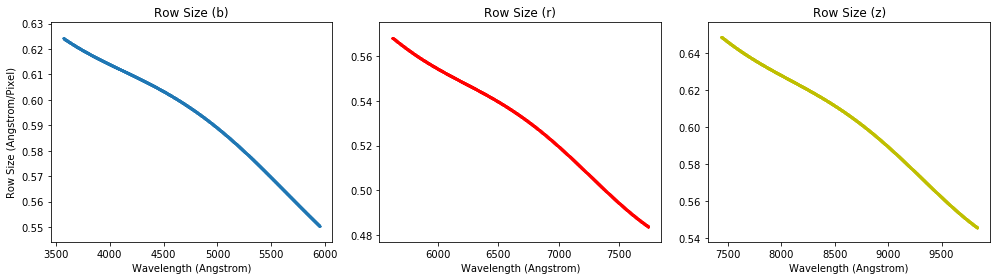

In [273]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))


#units are in Angstroms/Pixel
ax1.scatter(quicksim_b['wavelength'], quicksim_b['angstroms_per_row'], s=1)
ax2.scatter(quicksim_r['wavelength'], quicksim_r['angstroms_per_row'], s=1, c='r')
ax3.scatter(quicksim_z['wavelength'], quicksim_z['angstroms_per_row'], s=1, c='y')

ax1.set_title('Row Size (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('Row Size (Angstrom/Pixel)')
ax2.set_title('Row Size (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
ax3.set_title('Row Size (z)')
ax3.set_xlabel('Wavelength (Angstrom)')

plt.tight_layout()
plt.show()

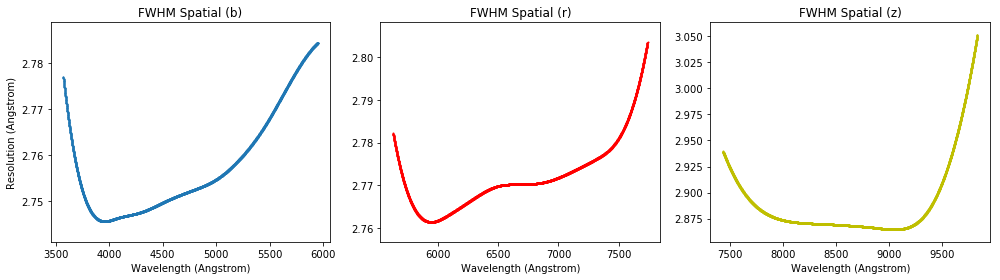

In [289]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))


#wave vs spatial???
ax1.scatter(quicksim_b['wavelength'], quicksim_b['fwhm_spatial'], s=1)
ax2.scatter(quicksim_r['wavelength'], quicksim_r['fwhm_spatial'], s=1, c='r')
ax3.scatter(quicksim_z['wavelength'], quicksim_z['fwhm_spatial'], s=1, c='y')

ax1.set_title('FWHM Spatial (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('Resolution (Angstrom)')
ax2.set_title('FWHM Spatial (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
ax3.set_title('FWHM Spatial (z)')
ax3.set_xlabel('Wavelength (Angstrom)')

plt.tight_layout()
plt.show()

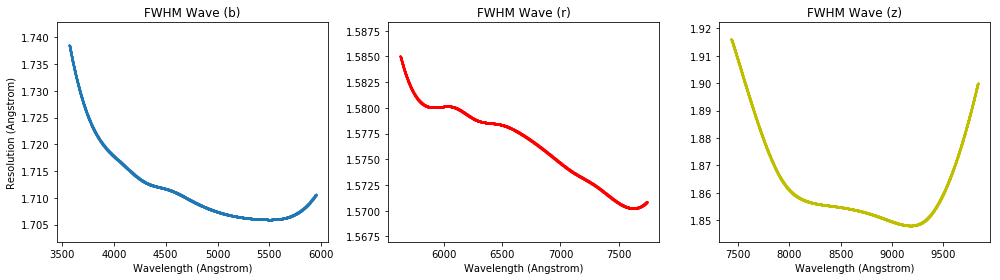

In [290]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))


#wave vs spatial???
ax1.scatter(quicksim_b['wavelength'], quicksim_b['fwhm_wave'], s=1)
ax2.scatter(quicksim_r['wavelength'], quicksim_r['fwhm_wave'], s=1, c='r')
ax3.scatter(quicksim_z['wavelength'], quicksim_z['fwhm_wave'], s=1, c='y')

ax1.set_title('FWHM Wave (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('Resolution (Angstrom)')
ax2.set_title('FWHM Wave (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
ax3.set_title('FWHM Wave (z)')
ax3.set_xlabel('Wavelength (Angstrom)')

plt.tight_layout()
plt.show()

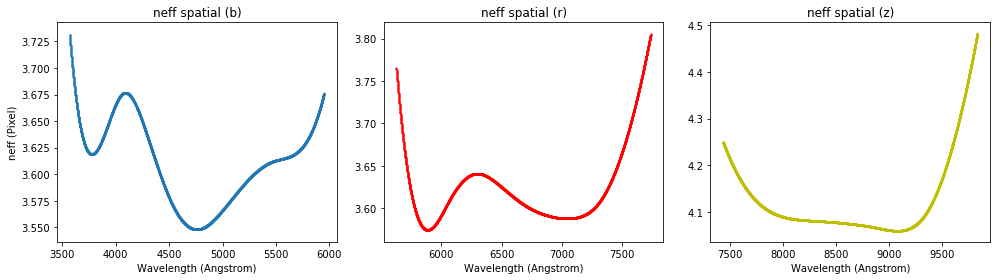

In [275]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14,4))

ax1.scatter(quicksim_b['wavelength'], quicksim_b['neff_spatial'], s=1)
ax2.scatter(quicksim_r['wavelength'], quicksim_r['neff_spatial'], s=1, c='r')
ax3.scatter(quicksim_z['wavelength'], quicksim_z['neff_spatial'], s=1, c='y')

ax1.set_title('neff spatial (b)')
ax1.set_xlabel('Wavelength (Angstrom)')
ax1.set_ylabel('neff (Pixel)')
ax2.set_title('neff spatial (r)')
ax2.set_xlabel('Wavelength (Angstrom)')
ax3.set_title('neff spatial (z)')
ax3.set_xlabel('Wavelength (Angstrom)')

plt.tight_layout()
plt.show()